In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import math
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

def generate_interior_data(filename, var, nx=None, nz=None, device='cpu'):
    """
    Read CSV data and return torch tensors.
    Array containing the u values reshaped to (nx, nz) if dimensions provided,
    otherwise returns the raw data as torch tensors
    """
    try:
        # Read the CSV file
        data = pd.read_csv(filename)
        
        # Verify the required columns exist
        required_cols = ['x', 'z', var]
        if not all(col in data.columns for col in required_cols):
            raise ValueError(f"CSV must contain columns: {required_cols}")
        
        # Create coordinate tensor
        X_data_np = np.column_stack((data['x'].values, data['z'].values))
        X_data = torch.tensor(X_data_np, dtype=torch.float64, requires_grad=True, device=device)
        
        if nx is not None and nz is not None:
            # Get unique x and z values
            unique_x = np.sort(data['x'].unique())
            unique_z = np.sort(data['z'].unique())
            
            # Verify the dimensions match
            if len(unique_x) != nx or len(unique_z) != nz:
                raise ValueError(f"Data dimensions ({len(unique_x)}, {len(unique_z)}) "
                               f"don't match specified dimensions ({nx}, {nz})")
            
            # Reshape the data into a 2D grid and convert to torch tensor
            u_values = data[var].values.reshape((nx, nz))
            u_data = torch.tensor(u_values, dtype=torch.float64, device=device)
        else:
            # Return the raw data as torch tensor if dimensions aren't specified
            u_data = torch.tensor(data[var].values, dtype=torch.float32, device=device)
            
        return X_data, u_data
            
    except Exception as e:
        print(f"Error reading or processing data: {str(e)}")
        raise


import torch
import torch

def sample_interior_data(X_data, u_data, num_samples=1000,
                         x_mean=500.0, x_std=250.0,
                         z_decay_rate=0.00925,
                         device='cpu'):
    """
    Sample (x,z) points from an existing dataset according to:
      • x ~ Normal(mean=500, std=150)
      • z = 1000 - y, y ~ Exponential(rate=0.05), clipped at z>=0

    Removes any points where z > 950 before sampling.
    Then picks u_data at those sampled indices.
    """
    # move to device
    X = X_data.to(device)
    u = u_data.to(device)

    # extract coords (N,1)
    x_coords = X[:, 0:1]
    z_coords = X[:, 1:2]

    # 0) filter out points where z > 950
    mask = (z_coords <= 950.0).squeeze()  # shape (N,)
    X = X[mask]
    u = u[mask]
    x_coords = X[:, 0:1]
    z_coords = X[:, 1:2]

    # 1) build sampling weights over the existing grid
    #    a) Gaussian weight for x
    x_weights = torch.exp(-((x_coords - x_mean) ** 2) / (2 * x_std ** 2))
    #    b) Exponential weight for z (max at z=1000)
    z_max = 1000.0
    z_weights = torch.exp(-z_decay_rate * (z_max - z_coords))

    # 2) combine and normalize
    weights = (x_weights * z_weights).squeeze()    # shape (M,)
    probs   = weights / weights.sum()

    # 3) sample indices
    idx = torch.multinomial(probs, num_samples, replacement=True)

    # 4) return sampled points + u’s
    return X[idx], u[idx]

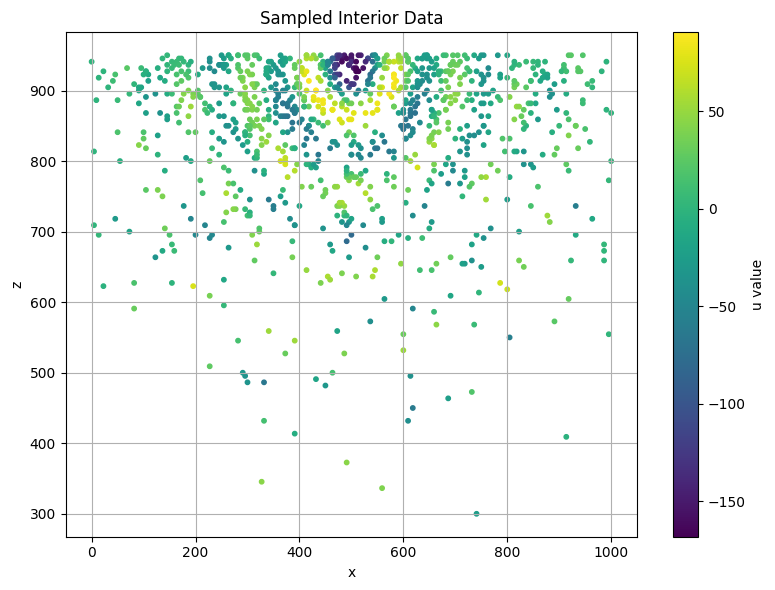

In [12]:
import matplotlib.pyplot as plt

# Load and sample data
X_data, u_data = generate_interior_data('data/real_part_0.0120Hz.csv', var='u', device='cpu')
sampled_X, sampled_u = sample_interior_data(X_data, u_data, num_samples=1000, device='cpu')

# Extract x and z coordinates
x_sampled = sampled_X[:, 0].detach().numpy()
z_sampled = sampled_X[:, 1].detach().numpy()
u_sampled = sampled_u.cpu().detach().numpy()

# Create scatter plot
plt.figure(figsize=(8, 6))
sc = plt.scatter(x_sampled, z_sampled, c=u_sampled, cmap='viridis', s=10)
plt.colorbar(sc, label='u value')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Sampled Interior Data')
plt.grid(True)
plt.tight_layout()
plt.show()
